# Python for MBAs Final Project

### An easy way to fill out the starting lineup and pitchers to a scorecard for MLB games

Alright, wow, I can't belive it's already been seven weeks! Where has the time gone? 
Anyway let's jump into this project! 
One of my passions in life is baseball, the nerdiest atheltic sport imaginable. And one of the nerdiest things you can do while watching the nerdiest sport is keep score. This is done by recording each play of the game in a specific way on a specially designed sheet. See below:

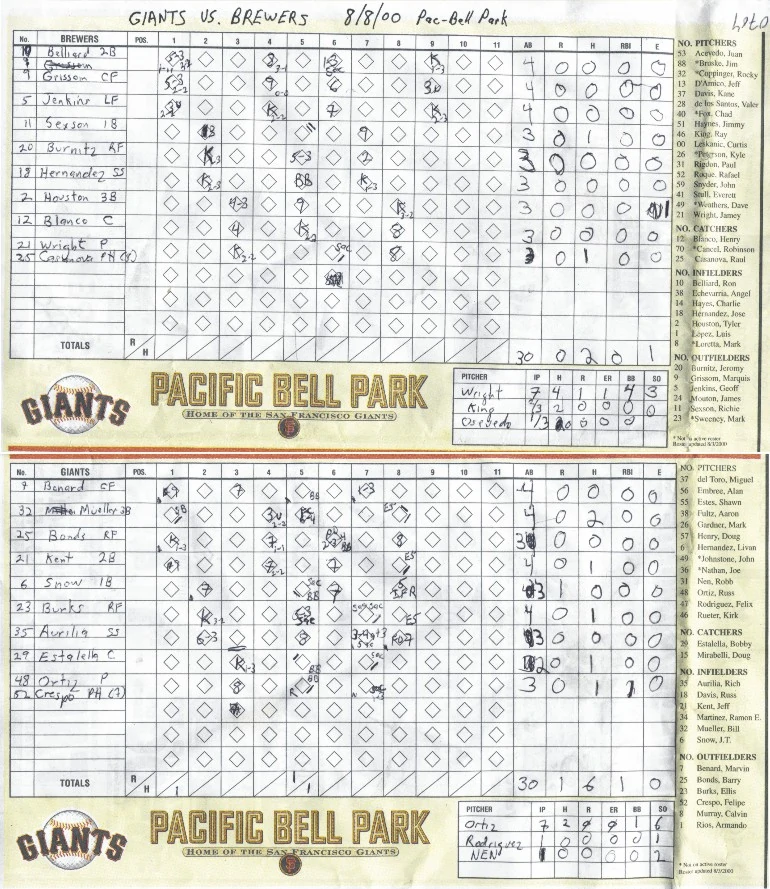

#### Whoa that's interesting! 
#### One of the most annoying parts of getting the scoresheet right happens just before or right as the game starts and the starting lineup is announced. Copying the starting 18 hitters and 2 pitchers is annoying, and MLB publishes the lineups to their website a few hours before the first pitch! Let's see if there's a way to automate this process.

First lets import some libraries that might be helpful:

In [1]:
import requests, re
import pandas as pd
import openpyxl
from bs4 import BeautifulSoup
from selenium import webdriver

#### Now let's go to the specific website we want to scrape data off of. Let's go with a game from 5/3/23, the first place Tornto Blue Jays vs. the cellar dwelling Boston Red Sox:

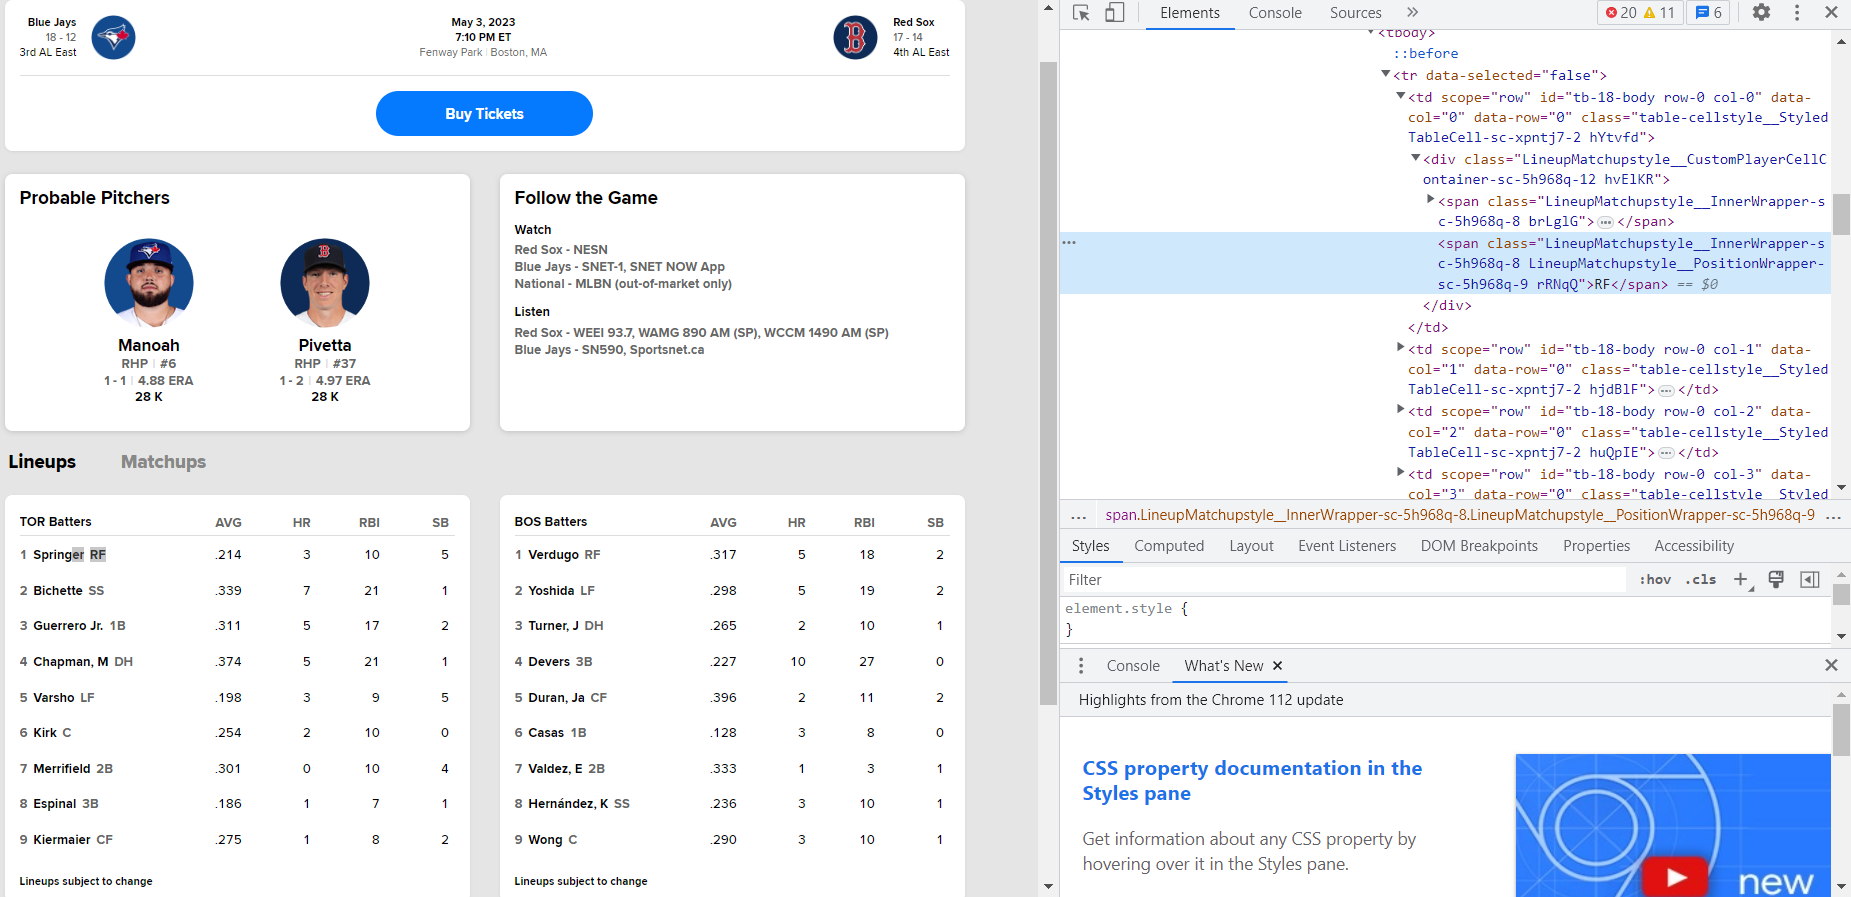

#### Ok so from this website, we can see that it has just about everything we want! We have our starting lineup and our starting pitchers. Lets use beautifulsoup to dig in and inspect how the html for this website is laid out:

In [4]:
site = 'https://www.mlb.com/gameday/blue-jays-vs-red-sox/2023/05/03/718323/preview'
driver = webdriver.Chrome()
driver.get(site)
html = driver.page_source
soup = BeautifulSoup(html)
soup

<html class="device-desktop no-touchevents pointerevents responsive-support-webkit responsive-support-use3d responsive-support-3d responsive-support-usetransition responsive-support-transition responsive-support-no-touch responsive-support-inlinevideo responsive-support-flex" lang="en"><head cfapps-selector="head"><script async="async" src="https://ans.mlb.com/b/ss/mlbglobal08,mlbcom08/10/JS-2.7.0/s75928777901267?AQB=1&amp;ndh=1&amp;pf=1&amp;callback=s_c_il[1].doPostbacks&amp;et=1&amp;t=3%2F4%2F2023%2019%3A22%3A17%203%20240&amp;d.&amp;nsid=0&amp;jsonv=1&amp;.d&amp;sdid=61D1832BB0EC970A-5C7C241CAB6ACBE7&amp;mid=60899282154510452043878187181395327439&amp;aamlh=7&amp;ce=UTF-8&amp;ns=mlb&amp;pageName=Major%20League%20Baseball%3A%20Gameday%3A%20Preview&amp;g=https%3A%2F%2Fwww.mlb.com%2Fgameday%2Fblue-jays-vs-red-sox%2F2023%2F05%2F03%2F718323%2Fpreview&amp;c.&amp;getQueryParam=4.0&amp;getPercentPageViewed=5.0.1&amp;.c&amp;cc=USD&amp;ch=Gameday&amp;events=event4&amp;aamb=6G1ynYcLPuiQxYZrsz_pk

#### Wow, thats a lot of html! It's crazy, but the info we want is in there! I'll spare you the trial and error here, dear TAs and profressor, but after many hours I eventually figured out how to parse this stuff to pull the data that's important to me

### Let's start by parsing out the starting pitchers:

In [6]:
pitch = soup.find_all('div', {'data-mlb-test':'playerNameLinks'}) 
# pitchers have a unique html identifier called playerNameLinks in the div tag
away_pitch = pitch[0].get_text() # extract the away pitcher
home_pitch = pitch[1].get_text() # extract the home pitcher
print(away_pitch, 'vs.', home_pitch) # show the output

Manoah vs. Pivetta


Cool! We managed to get the away and home starting pitchers in the right order! Let's move on to the batters and their position

In [12]:
player = soup.find_all('tbody') # all the players live under a tag called tbody
away_raw = player[0].find_all('tr') # away players are the first table row in tbody
home_raw = player[1].find_all('tr') # home players are the second table row in body
home_players = []
away_players = []

# get the home team starting lineup by name and position
for i in home_raw:
    (home_players.append(i.find_all('a')[0].get_text()+ # this is the players name. some players also have a first initial
                         ' ' + 
                         i.find_all('span', {'class' : re.compile('PositionWrapper*')})[0].get_text())) # this is players position

# the the away team starting lineup by name and position    
for i in away_raw:
    (away_players.append(i.find_all('a')[0].get_text()+ # this is the players name. some players also have a first initial
                         ' ' + 
                         i.find_all('span', {'class' : re.compile('PositionWrapper*')})[0].get_text())) # this is players position
print(home_players, away_players)

['Verdugo RF', 'Yoshida LF', 'Turner, J DH', 'Devers 3B', 'Duran, Ja CF', 'Casas 1B', 'Valdez, E 2B', 'Hernández, K SS', 'Wong C'] ['Springer RF', 'Bichette SS', 'Guerrero Jr. 1B', 'Chapman, M DH', 'Varsho LF', 'Kirk C', 'Merrifield 2B', 'Espinal 3B', 'Kiermaier CF']


Let's append the starting pitchers to the end of of the list of home and away players just for simplicity. I could probably have done this as a dictionary of dictionaries but I didn't have time. Maybe in the future.

In [13]:
home_players.append(home_pitch)
away_players.append(away_pitch)
print(home_players, away_players)

['Verdugo RF', 'Yoshida LF', 'Turner, J DH', 'Devers 3B', 'Duran, Ja CF', 'Casas 1B', 'Valdez, E 2B', 'Hernández, K SS', 'Wong C', 'Pivetta'] ['Springer RF', 'Bichette SS', 'Guerrero Jr. 1B', 'Chapman, M DH', 'Varsho LF', 'Kirk C', 'Merrifield 2B', 'Espinal 3B', 'Kiermaier CF', 'Manoah']


Now we have the starting lineup of each team, in the correct order, with the added bonus of getting their position as well, lets take that data and send it to a spreadsheet we setup for this purpose called data_pull.xlsx

In [15]:
# send our list out as a dataframe:
df = pd.DataFrame([away_players, home_players],
     index = ['away hitter', 'home hitter'])

# write to a predefined excel file
with pd.ExcelWriter("data_pull.xlsx", mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
    df.to_excel(writer, sheet_name="data_in")  

#### Stellar! This is what we get in our excel spreadsheet:

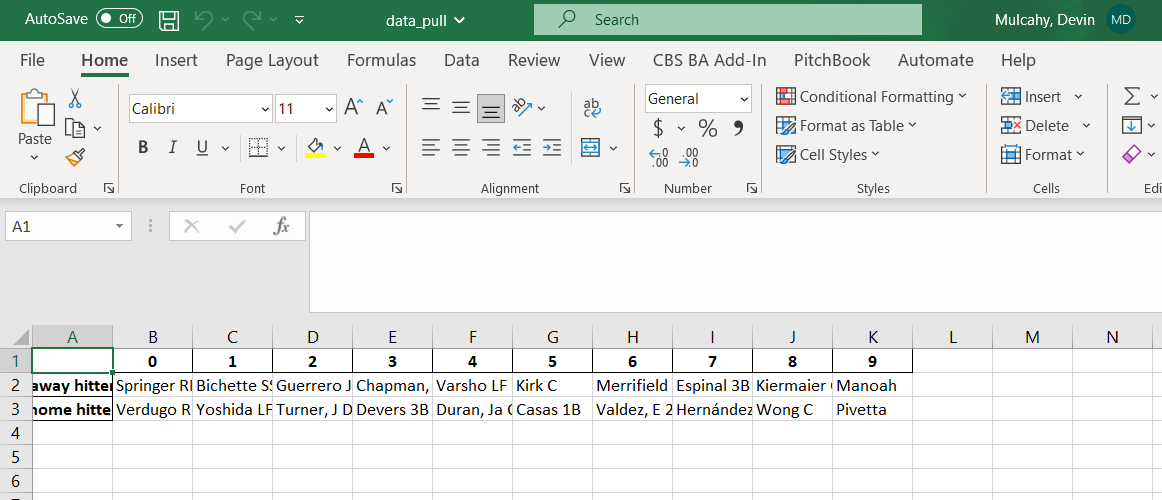

#### Looks good to me! We have the starting nine batters and the two starting pitchers in the right home/away lineup!

Using the data_pull.xls as a reference point, I made my own baseball scorecard that pulls the hitters and pitchers and put's them right where they need to! This is what it looks like:

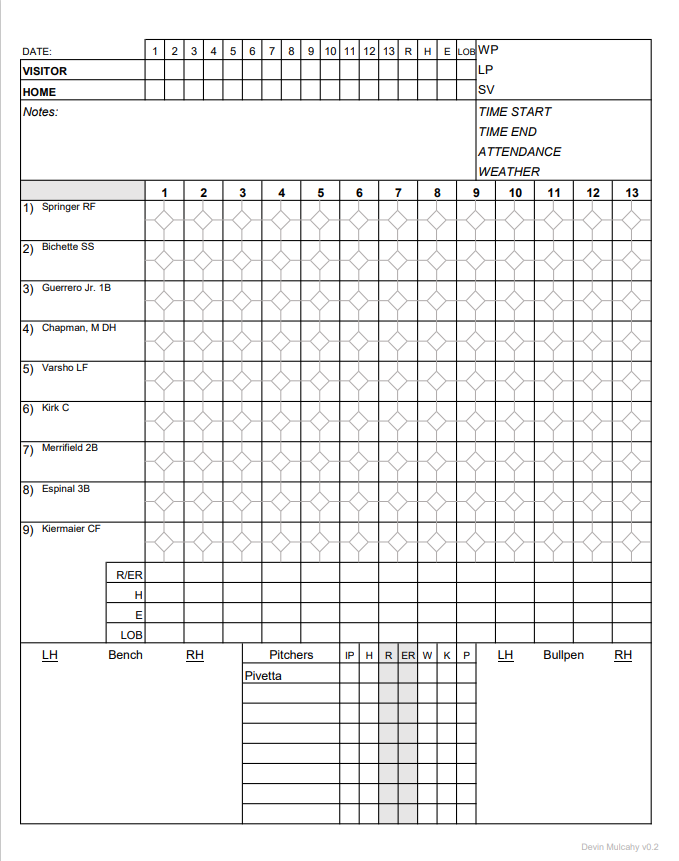
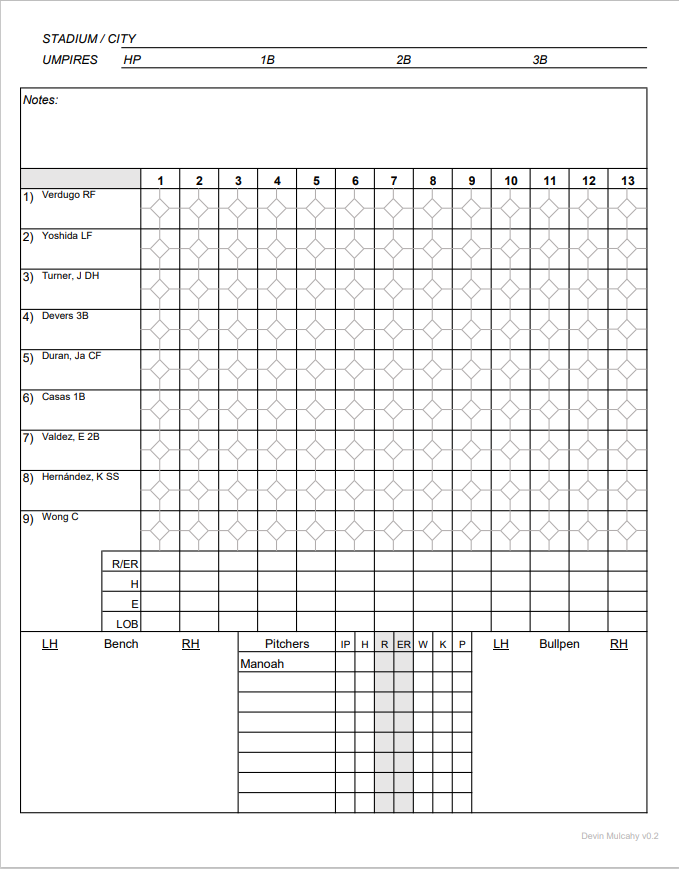

This looks pretty good! With some more time and effort I could probably import each teams bench and pullpen (the pitchers on the bench) as well as the stadium, weather, and umpires! But let's focus on getting everything automated into just one or two functions

## Function automation

Let's pull everything into a function that takes the target website as an argument and spits out the starting lineup as a dataframe

In [18]:
def get_starting_lineup(site):
    driver = webdriver.Chrome()
    driver.get(site)
    html = driver.page_source
    soup = BeautifulSoup(html)
    
    pitch = soup.find_all('div', {'data-mlb-test':'playerNameLinks'}) 
    # pitchers have a unique html identifier called playerNameLinks in the div tag
    away_pitch = pitch[0].get_text() # extract the away pitcher
    home_pitch = pitch[1].get_text() # extract the home pitcher
    player = soup.find_all('tbody') # all the players live under a tag called tbody
    away_raw = player[0].find_all('tr') # away players are the first table row in tbody
    home_raw = player[1].find_all('tr') # home players are the second table row in body
    home_players = []
    away_players = []

    # get the home team starting lineup by name and position
    for i in home_raw:
        (home_players.append(i.find_all('a')[0].get_text()+ # this is the players name. some players also have a first initial
                             ' ' + 
                             i.find_all('span', {'class' : re.compile('PositionWrapper*')})[0].get_text())) # this is players position

    # the the away team starting lineup by name and position    
    for i in away_raw:
        (away_players.append(i.find_all('a')[0].get_text()+ # this is the players name. some players also have a first initial
                             ' ' + 
                             i.find_all('span', {'class' : re.compile('PositionWrapper*')})[0].get_text())) # this is players position
    # print(home_players, away_players)
    home_players.append(home_pitch)
    away_players.append(away_pitch)
    # send our list out as a dataframe:
    df = pd.DataFrame([away_players, home_players],
         index = ['away hitter', 'home hitter'])
    return df

Let's test this out with another game from 5/3/23. How about the NY Mets at the Detroit Tigers

In [19]:
get_starting_lineup('https://www.mlb.com/gameday/mets-vs-tigers/2023/05/03/718348/preview')

,0,1,2,3,4,5,6,7,8,9
away hitter,Nimmo CF,"Marte, S RF",Lindor SS,Alonso 1B,Pham LF,McNeil 2B,Canha DH,Baty 3B,Nido C,Lucchesi
home hitter,Vierling RF,"Báez, J SS","Greene, R CF",Haase DH,Torkelson 1B,"Schoop, J 2B",Ibáñez LF,Rogers C,Short 3B,Wentz


HELL YEAH! It looks like this works for any MLB game!

Let's write a function that takes a dataframe as an argument and writes it to an excel spreadsheet that is the reference for our scorebard

In [21]:
def write_to_excel(df):
    with pd.ExcelWriter("data_pull.xlsx", mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
        df.to_excel(writer, sheet_name="data_in")  

In [23]:
write_to_excel(get_starting_lineup('https://www.mlb.com/gameday/mets-vs-tigers/2023/05/03/718348/preview'))

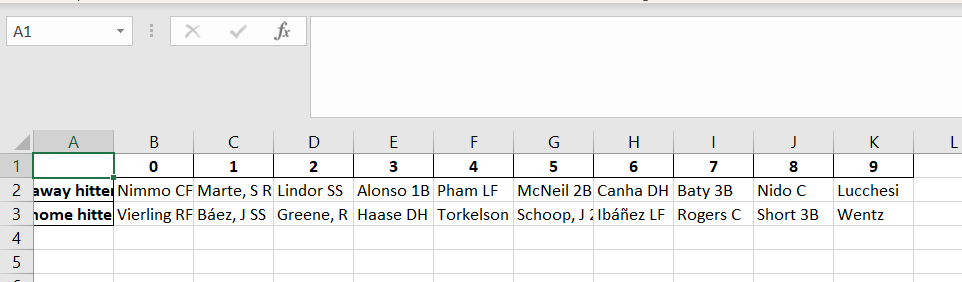

Ok looks like that works!

Now let's write one function that ties everything together

In [24]:
def populate_scorecard(url):
    try:
        df = get_starting_lineup(url)
        write_to_excel(df)
    except:
        print('error occured somewhere') # try and do some graceful error handling

#### lets try this with a different game today just to make sure everything is running smoothly
#### how about the Baltimore Orioles at the Kansas City Royals. It should look similar to this:
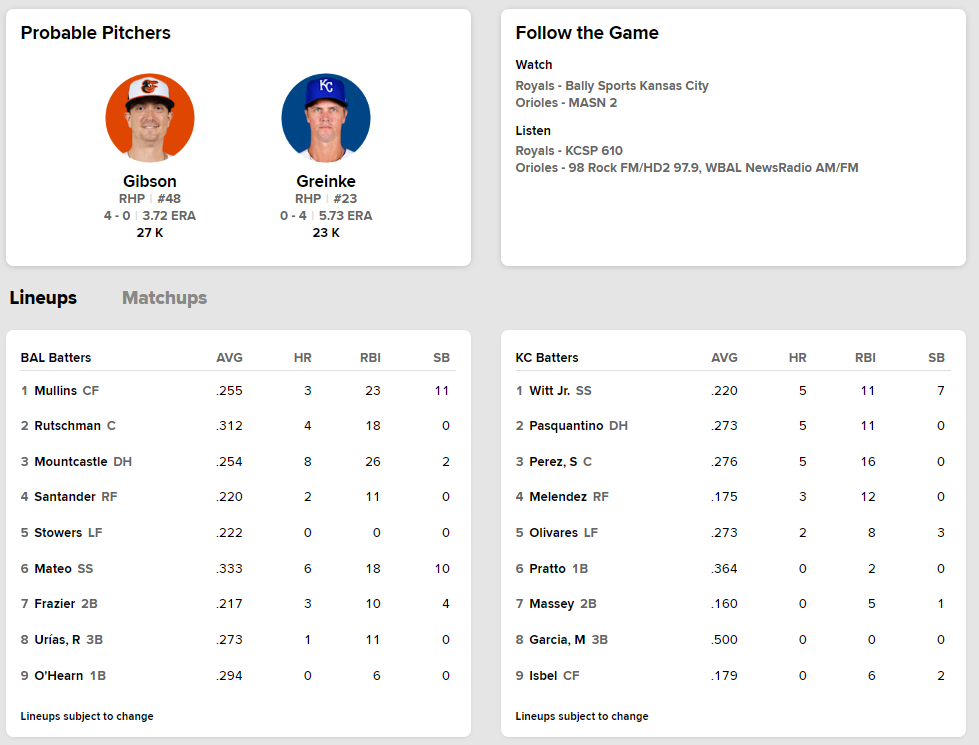

In [25]:
populate_scorecard('https://www.mlb.com/gameday/orioles-vs-royals/2023/05/03/718314/preview')

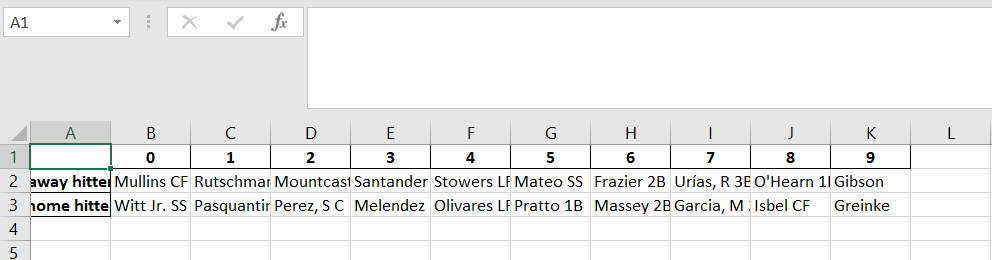

### Success!!

### Well, there you have it, a simple and easy way to easily populate a baseball scorecard with a teams starting lineup from the MLB website! 